In [4]:
import numpy as np
import tensorflow as tf 
import graphviz
import pydot

from scipy.integrate import solve_ivp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time
from multiprocessing import Process
import concurrent.futures

#import os
#os.environ["PATH"] += os.pathsep + 'C:\Anaconda3\Library\bin\graphviz'

from tensorflow import keras
from tensorflow.keras.layers import Dense, Lambda, Concatenate

In [125]:
N_h1 = 100
N_h2 = 100
N_h3 = 300
N_h4 = 300 
N_h5 = 300

N_vars = 3
N_seq = 11
N_out = 2

#Functional API model 
inputs = keras.Input(shape=(N_vars, N_seq), name="NN_Inputs")
#inputs = keras.Input(shape=(N_seq, N_vars), name="NN_Inputs")
flat = keras.layers.Flatten(name="Flatten_Layer")(inputs)

#Split input variables such that there is N_vars small networks with input size N_seq  
V_c, dVc_dt, V = tf.split(flat, num_or_size_splits=N_vars, axis=1, name="Split_Vars_Layer")
x_mult = tf.multiply(x1, x2, name="Multiplication")
x_delta = tf.subtract(x1, x2, name="Delta_V")
#x_n = tf.split(flat, num_or_size_splits=N_seq, axis=1, name="Split_Vars_Layer")

#Each mini-network will have one hidden layer. 
x1 = Dense(N_h1, activation='relu', name="Hidden_Layer_1_var1")(V_c)
x2 = Dense(N_h1, activation='relu', name="Hidden_Layer_1_var2")(dVc_dt)
x3 = Dense(N_h1, activation='relu', name="Hidden_Layer_1_var3")(V)
#x_n = [Dense(N_h1, activation='relu', name=f"Hidden_Layer_1_var{i}")(x) for i, x in enumerate(x_n)]

#Merge the layers with Concatinate 
x_m = Concatenate(axis=-1, name="Merge_Layers")([x1, x2, x3])#, x_mult, x_delta])
#x_m = Concatenate(axis=-1, name="Merge_Layers")(x_n)

#One last hidden layer (or more layers)
x_m = Dense(N_h4, activation='relu', name="Main_Hidden_Layer_1")(x_m)
#x_m = Dense(N_h5, activation='relu', name="Main_Hidden_Layer_2")(x_m)

#In addition, calculate R*C and send that as an output. 
sub = tf.subtract(V, V_c, name="V_over_R")
div = tf.divide(sub, dVc_dt)
RC = Dense(1, name="Calc_RC_Layer")(div)

#Output: 
NN_out = Dense(N_out, name="NN_Output_Layer")(x_m)
NN_out = Concatenate(axis=-1, name="Final_Output_layer")([NN_out, RC])

model = keras.Model(inputs=inputs, outputs=NN_out, name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
NN_Inputs (InputLayer)          [(None, 3, 11)]      0                                            
__________________________________________________________________________________________________
Flatten_Layer (Flatten)         (None, 33)           0           NN_Inputs[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Split_Vars_Layer_18 [(None, 11), (None,  0           Flatten_Layer[0][0]              
__________________________________________________________________________________________________
Hidden_Layer_1_var1 (Dense)     (None, 100)          1200        tf_op_layer_Split_Vars_Layer_18[0
_______________________________________________________________________________________

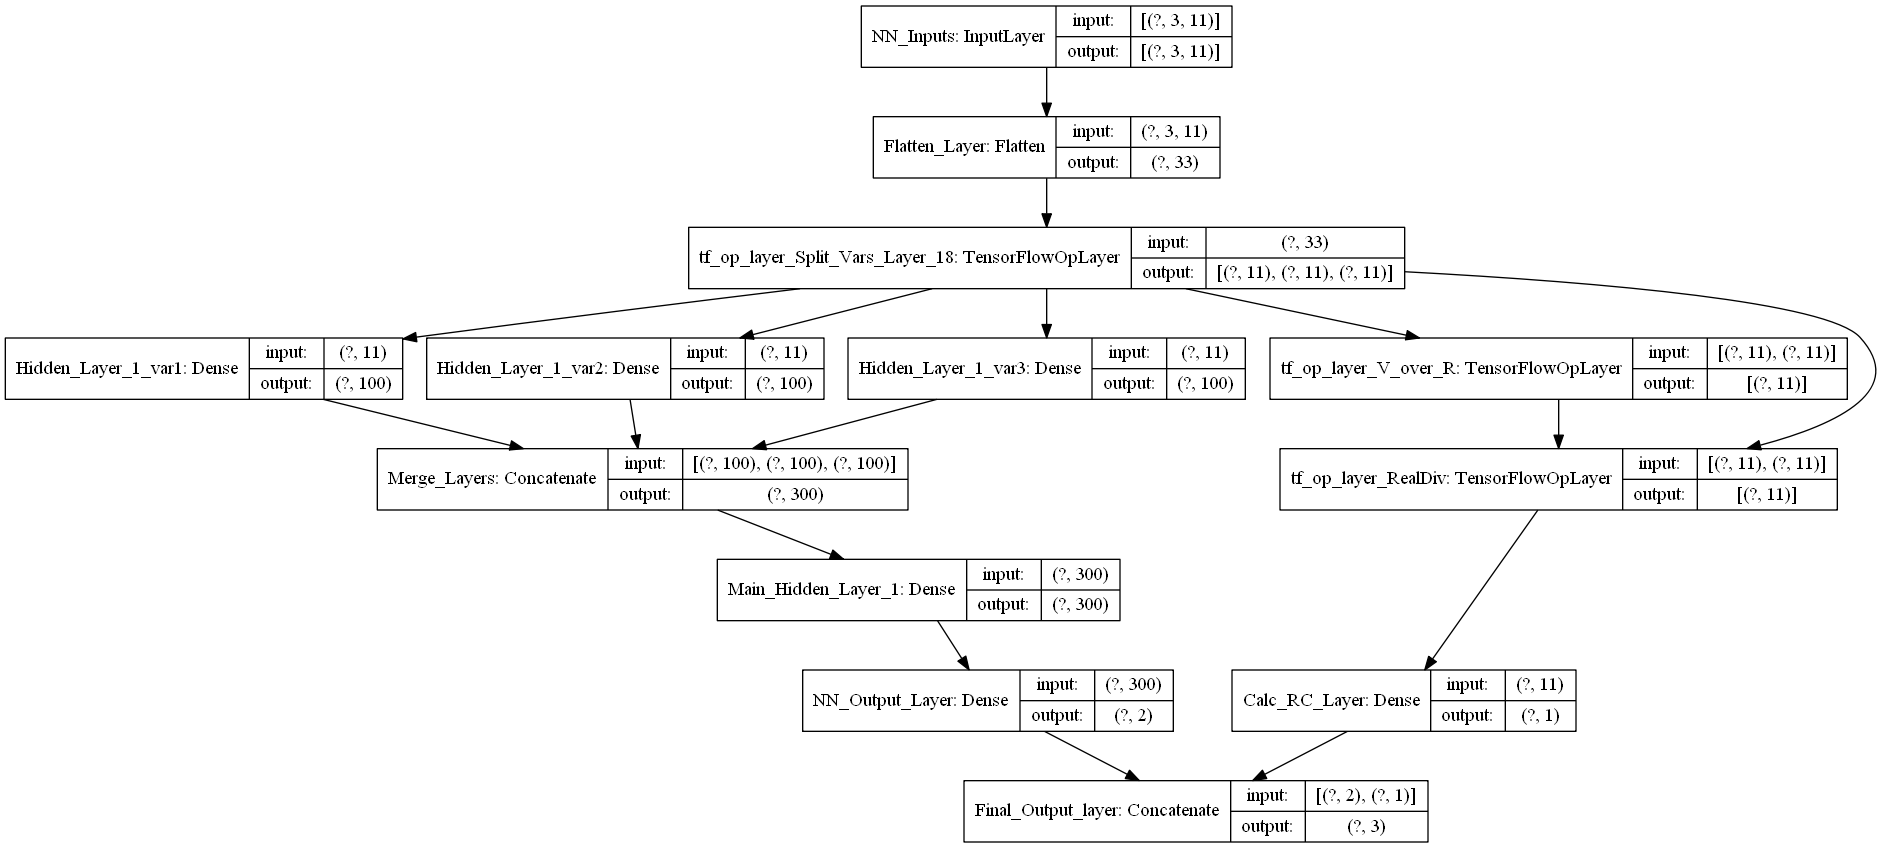

In [126]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [122]:
#x = [V_c], u = [V_in], theta = [R, C]

class diff_model: 
    def __init__(self):
        self.u_range = (0, 10)
        self.x0_range = [(0, 10)]
        self.theta_range = [(1, 5), (0.1, 0.2)]
        self.t0 = 0
        self.t1 = 1
        self.N_steps = 200 
        self.t = np.linspace(self.t0, self.t1, self.N_steps+1)
        self.t_disc = lambda t: (np.abs(self.t - t)).argmin()
    
    def reset(self): 
        self.u = self.generate_inputs()
        self.th = np.array([np.random.uniform(th[0], th[1]) for th in self.theta_range])
        self.th = np.append(self.th, self.th[0]*self.th[1])
        self.x0 = np.array([np.random.uniform(x0[0], x0[1]) for x0 in self.x0_range])
        
    def model(self, t, x): 
        u = self.u[self.t_disc(t)]
        return (u - x)/self.th[1]/self.th[0]
    
    def generate_inputs(self, change=0.01): 
        u = [] 
        for i in range(len(self.t)):
            if i == 0: 
                u_el = np.random.uniform(self.u_range[0], self.u_range[1])
            if np.random.rand() < change:
                u_el = np.random.uniform(self.u_range[0], self.u_range[1])
            u.append(u_el)            
        return u
    
    def solve_model(self, N_el):
        dN = self.N_steps//N_el
        self.reset()
        sol = solve_ivp(self.model, (0, 1), self.x0, t_eval=self.t[::dN])
        t_sol = []
        for t in sol.t:
            t_sol.append(ode_model.t_disc(t)) 
        u_sol = np.take(self.u, t_sol)
        x_sol = sol.y[0]
        dx_sol = np.gradient(x_sol)
        
        return x_sol, dx_sol, u_sol, self.th, sol
    
    def solve_N_model(self, N): #N = [N_sim, N_el]
        X_NN = []
        y_NN = []
        N_sim, N_el = N
        for i in range(N_sim): 
            x_sol, dx_sol, u_sol, th, _ = self.solve_model(N_el)
            X_NN.append([x_sol, dx_sol, u_sol])
            y_NN.append(th)
            
        X_NN = np.array(X_NN)
        y_NN = np.array(y_NN)
        X_scaler = MinMaxScaler(feature_range=(-1,1)) 
        y_scaler = MinMaxScaler() 
        self.X_scalers = []
        for i in range(len(X_NN[0])):
            self.X_scalers.append(X_scaler.fit(X_NN[:, i, :].reshape(-1, 1)))
        self.y_scaler = y_scaler.fit(y_NN)
        
        X_NN_scaled = [] 
        for X in X_NN: 
            X_el = []
            for X_var, X_scale in zip(X, self.X_scalers): 
                X_el.append(X_scale.transform([X_var])[0])
            X_NN_scaled.append(X_el)
        X_NN_scaled = np.array(X_NN_scaled)
        y_NN_scaled = self.y_scaler.transform(y_NN)
        
        return X_NN, y_NN, X_NN_scaled, y_NN_scaled
    
    def solve_N_model_multi(self, N): #NOT WORKING
        n_processes = 4
        N_sim_per_process = N[0]//n_processes 
        i = 0
        with concurrent.futures.ProcessPoolExecutor() as executor: 
            results = [executor.submit(self.solve_N_model, N) for _ in range(n_processes)]
            for f in concurrent.futures.as_completed(results): 
                if i == 0: 
                    X_NN, y_NN, X_NN_sc, y_NN_sc = f.result() #To get result
                    i += 1
                else:
                    X_NN_, y_NN_, X_NN_sc_, y_NN_sc_ = f.result() #To get result
                    X_NN = np.append(X_NN, X_NN_, axis=0)
                    y_NN = np.append(y_NN, y_NN_, axis=0)
                    X_NN_sc = np.append(X_NN_sc, X_NN_sc_, axis=0)
                    y_NN_sc = np.append(y_NN_sc, y_NN_sc_, axis=0)
        return X_NN, y_NN, X_NN_sc, y_NN_sc
                    
    def scale_data(self): 
        pass
        

In [342]:
#x = [V_c], u = [V_in], theta = [R, C]

class diff_model: 
    def __init__(self):
        self.u_range = (0, 10)
        self.x0_range = [(0, 10)]
        self.theta_range = [(1, 5), (0.1, 0.2)]
        self.t0 = 0
        self.t1 = 1
        self.N_steps = 200 
        self.t = np.linspace(self.t0, self.t1, self.N_steps+1)
        self.t_disc = lambda t: (np.abs(self.t - t)).argmin()
    
    def reset(self): 
        self.u = self.generate_inputs()
        self.th = np.array([np.random.uniform(th[0], th[1]) for th in self.theta_range])
        self.x0 = np.array([np.random.uniform(x0[0], x0[1]) for x0 in self.x0_range])
        
    def model(self, t, x): 
        u = self.u[self.t_disc(t)]
        return (u - x)/self.th[1]/self.th[0]
    
    def generate_inputs(self, change=0.01): 
        u = [] 
        for i in range(len(self.t)):
            if i == 0: 
                u_el = np.random.uniform(self.u_range[0], self.u_range[1])
            if np.random.rand() < change:
                u_el = np.random.uniform(self.u_range[0], self.u_range[1])
            u.append(u_el)            
        return u
    
    def solve_model(self, N_el):
        dN = self.N_steps//N_el
        self.reset()
        sol = solve_ivp(self.model, (0, 1), self.x0, t_eval=self.t[::dN])
        t_sol = []
        for t in sol.t:
            t_sol.append(ode_model.t_disc(t)) 
        u_sol = np.take(self.u, t_sol)
        x_sol = np.append([self.x0[0]], sol.y[0])[:-1]
        dx_sol = np.gradient(x_sol)
        dV = (u_sol - x_sol) 
        P = dV**2/self.th[0] 
        I = dV/self.th[0]
        
        return x_sol, dx_sol, u_sol, self.th, P, I
    
    def solve_N_model(self, N): #N = [N_sim, N_el]
        X_NN = []
        y1_NN = []
        y2_NN = []
        N_sim, N_el = N
        for i in range(N_sim): 
            x_sol, dx_sol, u_sol, th, P, I = self.solve_model(N_el)
            X_NN.append([x_sol, u_sol])
            y1_NN.append(th)
            y2_NN.append(np.append(P, I))
            
        X_NN = np.array(X_NN)
        y1_NN = np.array(y1_NN)
        y2_NN = np.array(y2_NN)
        y1_scaler = MinMaxScaler() 
        y2_scaler = MinMaxScaler() 
        self.X_scalers = []
        for i in range(len(X_NN[0])):
            X_scaler = MinMaxScaler(feature_range=(-1,1)) 
            self.X_scalers.append(X_scaler.fit(X_NN[:, i, :].reshape(-1, 1)))
        self.y1_scaler = y1_scaler.fit(y1_NN)
        self.y2_scaler = y2_scaler.fit(y2_NN)
        
        X_NN_scaled = [] 
        for X in X_NN: 
            X_el = []
            for X_var, X_scale in zip(X, self.X_scalers): 
                X_el.append(X_scale.transform([X_var])[0])
            X_NN_scaled.append(X_el)
        X_NN_scaled = np.array(X_NN_scaled)
        y1_NN_scaled = self.y1_scaler.transform(y1_NN)
        y2_NN_scaled = self.y2_scaler.transform(y2_NN)
        
        return X_NN, y1_NN, y2_NN, X_NN_scaled, y1_NN_scaled, y2_NN_scaled
    
    def solve_N_model_multi(self, N): #NOT WORKING
        n_processes = 4
        N_sim_per_process = N[0]//n_processes 
        i = 0
        with concurrent.futures.ProcessPoolExecutor() as executor: 
            results = [executor.submit(self.solve_N_model, N) for _ in range(n_processes)]
            for f in concurrent.futures.as_completed(results): 
                if i == 0: 
                    X_NN, y_NN, X_NN_sc, y_NN_sc = f.result() #To get result
                    i += 1
                else:
                    X_NN_, y_NN_, X_NN_sc_, y_NN_sc_ = f.result() #To get result
                    X_NN = np.append(X_NN, X_NN_, axis=0)
                    y_NN = np.append(y_NN, y_NN_, axis=0)
                    X_NN_sc = np.append(X_NN_sc, X_NN_sc_, axis=0)
                    y_NN_sc = np.append(y_NN_sc, y_NN_sc_, axis=0)
        return X_NN, y_NN, X_NN_sc, y_NN_sc
                    
    def scale_data(self): 
        pass

In [343]:
t1 = time.time()
ode_model = diff_model()
X_NN, y1_NN, y2_NN, X_NN_sc, y1_NN_sc, y2_NN_sc = ode_model.solve_N_model((20000, 10)) #N_sim, N_el
print(f"Command took {time.time()-t1} seconds.")

Command took 54.9134738445282 seconds.


In [344]:
N_h1 = 80
N_h2 = 180

N_vars = 2
N_seq = 11
N_out = 2

#Functional API model 
inputs = keras.Input(shape=(N_vars, N_seq), name="Variables")
inputs2 = keras.layers.Flatten(name="Flatten")(inputs)
NN = Dense(N_h1, activation='relu', name="NN1")(inputs2)
NN = Dense(N_h2, activation='relu', name="NN2")(NN)

out1 = Dense(N_out, name="Out1")(NN)

V_c, V = tf.split(inputs2, num_or_size_splits=N_vars, axis=1, name="Split1") 
dV = tf.subtract(V, V_c)
dV2 = tf.multiply(dV, dV, name="Square_dV")
R, C = tf.split(out1, num_or_size_splits=N_vars, axis=1, name="Isolate_R")

I = tf.divide(dV, R, name="Calc_I")
P = tf.divide(dV2, R, name="Calc_P")
out2 = Concatenate(axis=1, name="Out2")([P, I])

model = keras.Model(inputs=inputs, outputs=[out1, out2], name="Param_est_NN")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

model.summary()

Model: "Param_est_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Variables (InputLayer)          [(None, 2, 11)]      0                                            
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 22)           0           Variables[0][0]                  
__________________________________________________________________________________________________
NN1 (Dense)                     (None, 80)           1840        Flatten[0][0]                    
__________________________________________________________________________________________________
NN2 (Dense)                     (None, 180)          14580       NN1[0][0]                        
_______________________________________________________________________________________

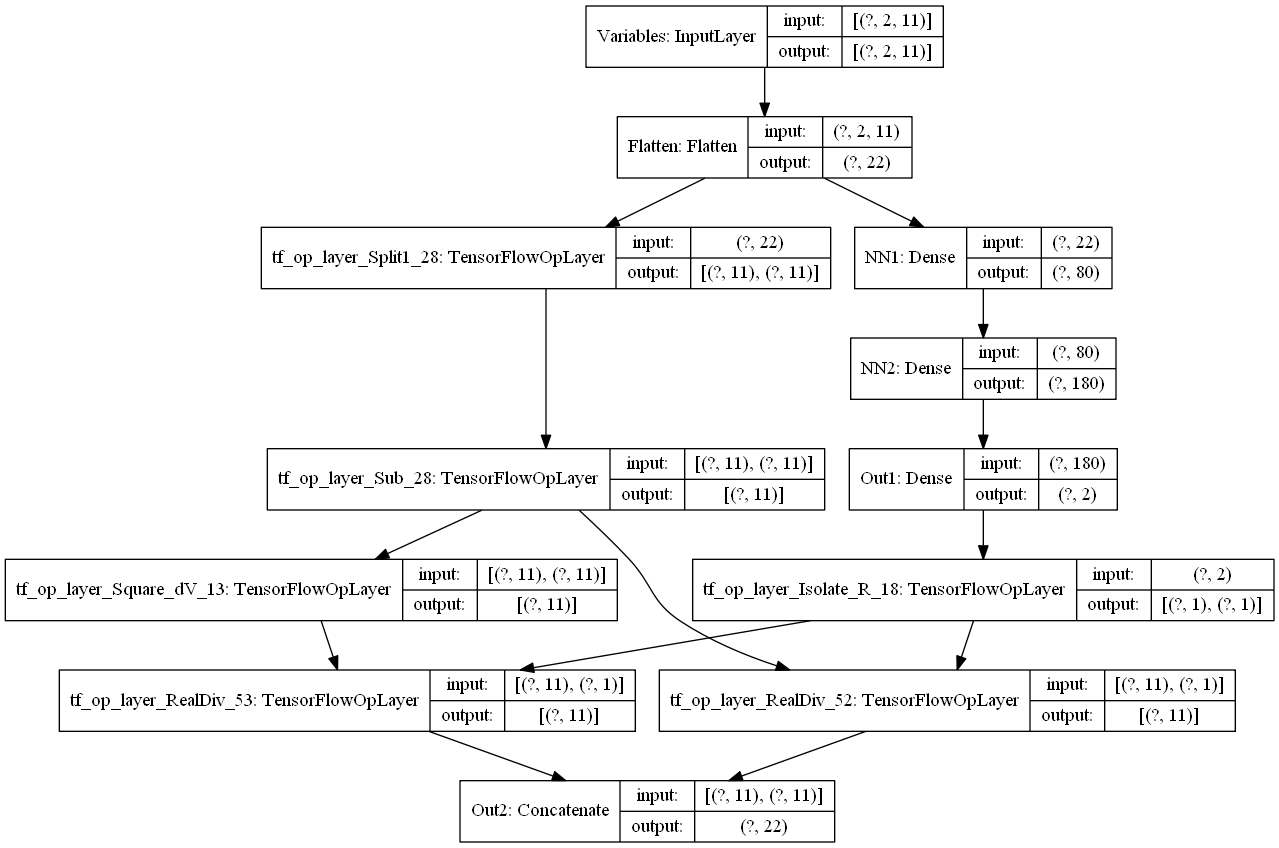

In [345]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [346]:
history = model.fit(X_NN_sc, [y1_NN_sc, y2_NN_sc], epochs=30, batch_size=32, verbose=2)

Epoch 1/30
625/625 - 1s - loss: 4.9680 - Out1_loss: 0.2274 - Out2_loss: 4.7406 - Out1_accuracy: 0.5021 - Out2_accuracy: 0.1528
Epoch 2/30
625/625 - 1s - loss: 0.5669 - Out1_loss: 0.2271 - Out2_loss: 0.3398 - Out1_accuracy: 0.4992 - Out2_accuracy: 0.1528
Epoch 3/30
625/625 - 1s - loss: 0.5520 - Out1_loss: 0.2164 - Out2_loss: 0.3355 - Out1_accuracy: 0.4992 - Out2_accuracy: 0.1528
Epoch 4/30
625/625 - 1s - loss: 0.5414 - Out1_loss: 0.2062 - Out2_loss: 0.3352 - Out1_accuracy: 0.4994 - Out2_accuracy: 0.1528
Epoch 5/30
625/625 - 1s - loss: 0.5370 - Out1_loss: 0.2024 - Out2_loss: 0.3346 - Out1_accuracy: 0.4995 - Out2_accuracy: 0.1528
Epoch 6/30
625/625 - 2s - loss: 0.5354 - Out1_loss: 0.2014 - Out2_loss: 0.3340 - Out1_accuracy: 0.4994 - Out2_accuracy: 0.1528
Epoch 7/30
625/625 - 2s - loss: 0.5344 - Out1_loss: 0.2008 - Out2_loss: 0.3336 - Out1_accuracy: 0.4996 - Out2_accuracy: 0.1528
Epoch 8/30
625/625 - 1s - loss: 0.5335 - Out1_loss: 0.2001 - Out2_loss: 0.3333 - Out1_accuracy: 0.4985 - Out2_a

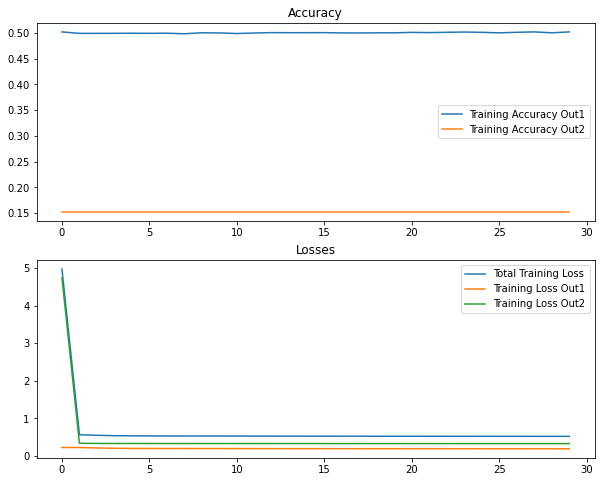

In [347]:
hist = history.history 

fig, ax = plt.subplots(2,1)
ax[0].set_title("Accuracy")
ax[0].plot(hist["Out1_accuracy"], label="Training Accuracy Out1")
ax[0].plot(hist["Out2_accuracy"], label="Training Accuracy Out2")
#ax[0].plots(hist["val_accuracy"], label="Validation Accuracy")
ax[0].legend() 

ax[1].set_title("Losses")
ax[1].plot(hist["loss"], label="Total Training Loss")
ax[1].plot(hist["Out1_loss"], label="Training Loss Out1")
ax[1].plot(hist["Out2_loss"], label="Training Loss Out2")
#ax[1].plot(hist["val_loss"], label="Validation Loss")
ax[1].legend()

fig.set_figwidth(10)
fig.set_figheight(8)
plt.show()

In [332]:
model.predict(X_NN)

[array([[-2.176645  ,  0.14770192],
        [-2.4365525 ,  0.21394953],
        [-7.904968  ,  0.26387227],
        ...,
        [-4.049634  ,  0.15972348],
        [-0.6709733 ,  0.14895579],
        [-8.402693  ,  0.08890823]], dtype=float32),
 array([[-1.2564985 , -1.2564985 , -0.6785603 , ..., -0.48970124,
         -0.109442  , -0.06296208],
        [-0.6742536 , -0.6742536 , -0.49532983, ..., -0.8898774 ,
         -1.4050146 , -1.2985759 ],
        [-5.5261946 , -5.5261946 , -0.45504704, ..., -0.03439177,
          0.82714957,  0.7090262 ],
        ...,
        [-6.8567276 , -6.8567276 , -4.4270134 , ...,  0.2815544 ,
          0.22631036,  0.18201536],
        [-2.3632112 , -2.3632112 , -1.4967922 , ...,  0.38097003,
          0.30310994,  0.24135317],
        [-7.327797  , -7.327797  , -3.6925447 , ...,  0.58338434,
          0.5026162 ,  0.35326734]], dtype=float32)]

In [334]:
y1_NN

array([[3.060416  , 0.10610656],
       [3.27861456, 0.19781077],
       [1.17092152, 0.1817958 ],
       ...,
       [3.98291475, 0.11479403],
       [2.30159953, 0.19028002],
       [2.77433986, 0.10522062]])

In [337]:
np.min(y2_NN)

-8.214630546420196